# Imports

First we import the discrete GRN dependencies.

In [1]:
from discrete_motif import DiscreteGrnMotif
import discrete_motif_functions as functions
import discrete_motif_measures as measures
import discrete_motif_generator as generator
import discrete_motif_operations as operations
import discrete_motif_plotting as visualize
from IPython.display import HTML, display
import logging
import os
import pickle
import random
import tabulate
import time
from time import gmtime, strftime

# t-sne imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# significance tests import
import scipy.stats

# set folders
data_location = "../../data"
log_location = "../../log"

# logger
mylogger = logging.getLogger('mylogger')
handler1 = logging.FileHandler(filename=os.path.join(log_location, 'experiments_%s.log' % strftime("%Y-%m-%d %H:%M:%S", gmtime())), mode='w')
handler1.setLevel(logging.DEBUG)
handler1.setFormatter(logging.Formatter('%(asctime)s [%(levelname)s] %(message)s'))
mylogger.addHandler(handler1)

# Settings

In [2]:
experiment = -1

if experiment == -1:
    # experiment using the joint_pdf nudge
    synergy_measure = measures.synergy_middleground
    nudge_method = "DJ"
    sample_size = 5
    network_sizes = [2, 3]
    logic_sizes = [2]
    nudge_sizes = [0.5]
if experiment == 0:
    # experiment using the joint_pdf nudge
    synergy_measure = measures.synergy_middleground
    nudge_method = "joint_pdf"
    sample_size = 20
    network_sizes = [2, 3]
    logic_sizes = [2]
    nudge_sizes = [0.5]
elif experiment == 1:
    # experiment using the DJ-version of a nudge
    synergy_measure = measures.synergy_middleground
    nudge_method = "DJ"
    sample_size = 500
    network_sizes = [2, 3, 4, 5, 6]
    logic_sizes = [2, 3, 4]
    nudge_sizes = [0.1, 0.25, 0.5]


# Data imports and sample

So far, we don't import data. In theory we want to compare three samples:

1. Random transition tables of the system state
2. Biological transition tables of the system state (still random samples, but with constraints)
3. Real GRN motifs

The last is difficult to draw a large sample from. Here we would import this sample, but I am focussing on the first two first.

In [ ]:
def loop_impacts(network_size, nudge_size, motif):
    impacts = []
    synergy = None
    
    # find the memory
    decay = measures.mi_decay(motif, 1)
    memory = decay[1] / decay[0]
    
    # try to find the synergy
    try:
        # find the synergy
        entropy = decay[0]
        motif.evaluate_motif()
        synergy = synergy_measure(motif)

        # normalize by dividing by the total entropy (not mutual information)
        if float(entropy) != 0:
            synergy = float(synergy)/float(entropy)
        else:
            raise ValueError("divide by zero avoided")
    except ValueError:
        print("divide by zero avoided: failed to find the synergy")
        synergy = None
    
    # try to loop
    for nudge_width in range(1, network_size + 1):
        if not (nudge_method == 'joint_pdf' and nudge_width == network_size):
            # sample a set to nudge
            options = list(range(0, network_size))
            random.shuffle(options)
            targets = []
            for i in range(0, nudge_width):
                targets.append(options[i])
            targets.sort()

            # find the nudge impact
            motif.reset_to_state(0)
            motif.evaluate_motif()
            motif.reset_to_state(0)
            operations.nudge_variable(motif, targets, nudge_size, nudge_method)
            motif.evaluate_motif()

            # we compare the two evolved states
            impact = measures.abs_diff(motif.states[-3], motif.states[-1])
            impact_tuple = (nudge_width, impact)
            impacts.append(impact_tuple)
    
    return synergy, impacts, memory

In [ ]:
def draw_sample(sample_size, network_size, logic_size, nudge_size):
    # let's store it in a dict, with some meta information
    print("Samping with %s nodes and %s-valued logic" % (network_size, logic_size))
    sample = {}
    sample["network_size"] = network_size
    sample["logic_size"] = logic_size
    sample["nudge_size"] = nudge_size
    sample["random_tables"] = generator.generate_random(sample_size, network_size, logic_size)
    sample["bio_tables"] = generator.generate_motifs(sample_size, network_size, logic_size)[0]

    # set transition tables
    # enrich the bio tables with synergy and a impact vector from 1 to system size
    counter = 0
    for motif in sample["bio_tables"]:
        motif.set_transition_table()

        synergy, impacts, memory = loop_impacts(network_size, nudge_size, motif)

        sample["bio_tables"][counter] = (motif, synergy, impacts, memory)
        counter += 1

    # enrich the random tables
    counter = 0
    for motif in sample["random_tables"]:
        synergy, impacts, memory = loop_impacts(network_size, nudge_size, motif)

        sample["random_tables"][counter] = (motif, synergy, impacts, memory)
        counter += 1
    
    return sample

In [ ]:
# in this cell we generate samples

samples = []
directory = "../../data"
if not os.path.isdir(directory):
    os.mkdir(directory)
    
# draw a few completely random samples, with different parameters
for network_size in network_sizes:
    for logic_size in logic_sizes:
        for nudge_size in nudge_sizes:
            mylogger.debug("sampling %d nodes, %d logic size, %f nudge size, %s as nudge_method, %s as synergy measure" % (network_size, logic_size, nudge_size, nudge_method, synergy_measure))
            start = time.time()
            sample = draw_sample(sample_size, network_size, logic_size, nudge_size)
            samples.append(sample)
            
            # save the data for future use/reruns
            name = "samples_n=%d_l=%d_e=%f_%s_%s_nosamples=%d.pkl" % (network_size, logic_size, nudge_size, nudge_method, synergy_measure, sample_size)

            with open(os.path.join(data_location, name), 'wb') as output:
                pickle.dump(sample, output, pickle.HIGHEST_PROTOCOL)
            end = time.time()
            mylogger.debug("sampled %d motifs" % sample_size)
            mylogger.debug("sample took %d seconds" % (end - start))
            
# we do not import real data yet

In [3]:
# load data back, start from this step to use previous run
samples = []
for root, dirnames, filenames in os.walk(data_location):
    for filename in filenames:
        if filename.endswith('.pkl'):
            with open(os.path.join(root, filename), 'rb') as input:
                samples.append(pickle.load(input))

# Data visualisation

We use t-SNE to visualize our sample. What we see makes perfect sense: the biological motifs seem to be a subset of the sample space. In higher valued logic systems, the space becomes larger, making the sample size insufficient. As t-SNE also does clustering, it then starts to appear that we have two seperate sample, but this is simply the separation from the very similar biological motifs from the rest.

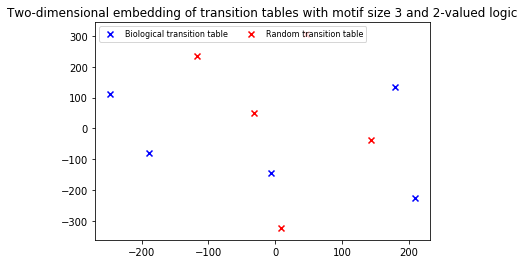

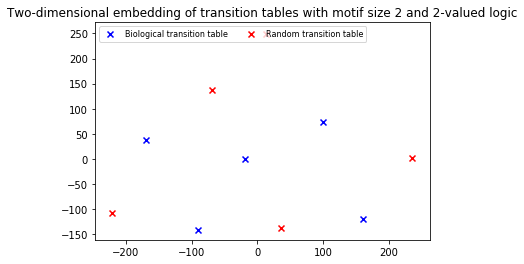

In [4]:
# x_train should be an array of N vectors of length M
# where N is the sample size and M is the length of the combined new state of the transition table
# we combine both the random and bio samples, but give them different colors

for i in range(0, len(samples)):
    x_train = []
    y_color = []
    labels = []
    # the random tables
    for sample in samples[i]["random_tables"]:
        table = sample[0]
        sample_vector = []
        for row in table.transition_table:
            sample_vector.extend(row[(len(row)/2):])
        y_color.append("red")
        x_train.append(sample_vector)
        labels.append("Random transition table")

    # the bio table
    for sample in samples[i]["bio_tables"]:
        motif = sample[0]
        sample_vector = []
        for row in motif.transition_table:
            sample_vector.extend(row[(len(row)/2):])
        y_color.append("blue")
        x_train.append(sample_vector)
        labels.append("Biological transition table")
 
    x_train = np.array(x_train)
    title = "Two-dimensional embedding of transition tables with motif size %s and %s-valued logic" % (samples[i]["network_size"], samples[i]["logic_size"])
    x_train_embedded = TSNE(n_components=2, perplexity=40, early_exaggeration=1, verbose=0).fit_transform(x_train)
    
    results_location = "../../data/n=%d_l=%d_e=%f_%s_%s_nosamples=%d" % (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], nudge_method, synergy_measure, len(samples[i]))
    if not os.path.isdir(results_location):
        os.mkdir(results_location)
    ilename = "tsne2D.pdf" 
    visualize.plot_scatter(x_train_embedded, y_color, labels, title, os.path.join(results_location, filename))

# Experiments

## Correlation between synergy and nudge resilience

We use the middle between the  WMS synergy, which is a lower bound, and the maximum individiual MI, which is an upper bound.

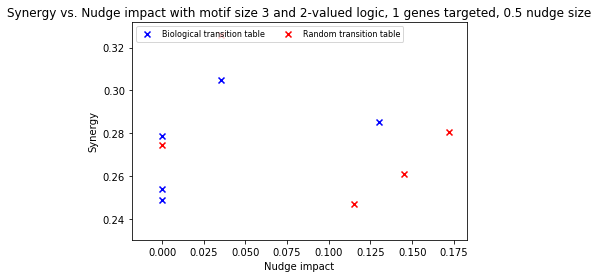

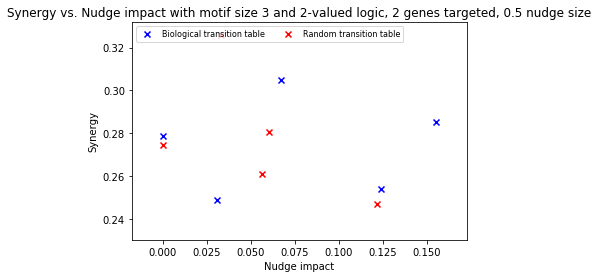

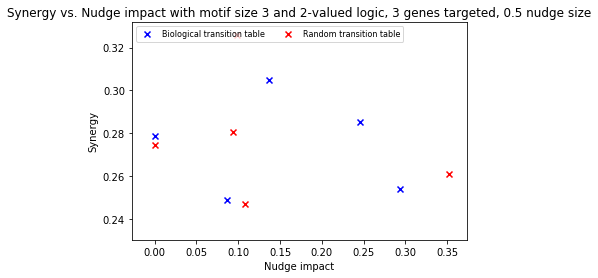

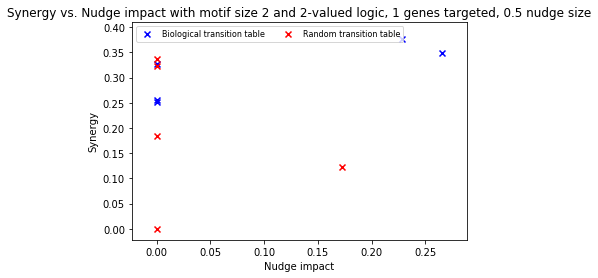

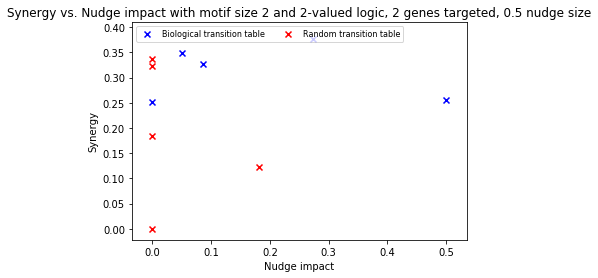

In [5]:
for i in range(0, len(samples)):
    for j in range(0, samples[i]["network_size"]):
        x_values = []
        colors = []
        labels = []
        title = "Synergy vs. Nudge impact with motif size %s and %s-valued logic, "\
                "%s genes targeted, %s nudge size" % \
                (samples[i]["network_size"], samples[i]["logic_size"], j+1, samples[i]["nudge_size"])
        axes_labels = ["Nudge impact", "Synergy"]
        # the random tables
        for sample in samples[i]["random_tables"]:
            if len(sample[2]) > 0:
                if sample[1] is not None and sample[2][j][1] is not None:
                    x_values.append([sample[2][j][1], sample[1]])
                    colors.append("red")
                    labels.append("Random transition table")

        # the bio table
        for sample in samples[i]["bio_tables"]:
            if len(sample[2]) > 0:
                if sample[1] is not None and sample[2][j][1] is not None:
                    x_values.append([sample[2][j][1], sample[1]])
                    colors.append("blue")
                    labels.append("Biological transition table")
            
        x_values = np.array(x_values)
        
        results_location = "../../data/n=%d_l=%d_e=%f_%s_%s_nosamples=%d" % (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], nudge_method, synergy_measure, len(samples[i]))
        filename = "scatter2D_synergy_resilience.pdf"
        visualize.plot_scatter(x_values, colors, labels, title, os.path.join(results_location, filename), axes_labels)

# Correlation Memory, Synergy and Nudge Impact

We also make a 3D version, to see if we can differentiate clusters based on memory (and maybe identify clusters that have good memory, but also good resilience, or clusters that are not interesting because they are always the same state).

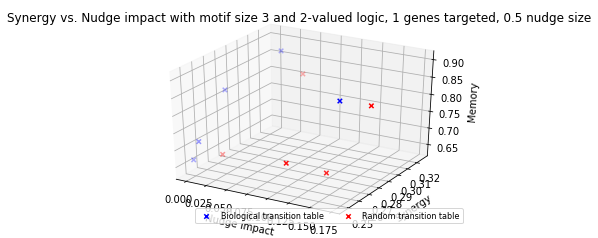

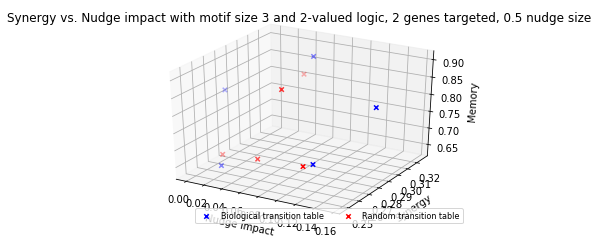

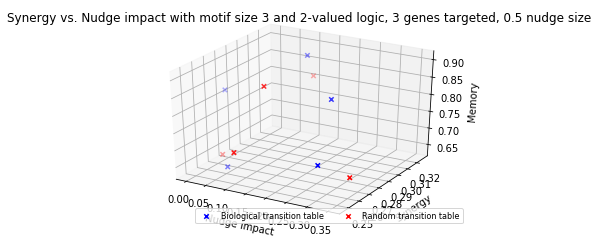

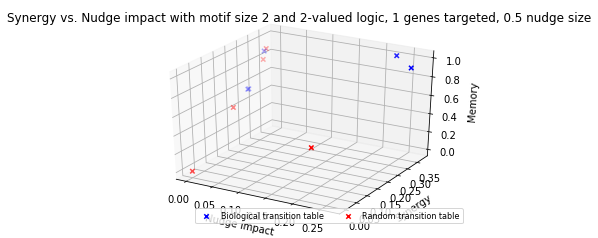

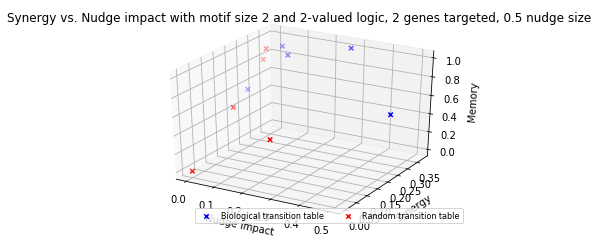

In [6]:
for i in range(0, len(samples)):       
    for j in range(0, samples[i]["network_size"]):
        x_values = []
        colors = []
        labels = []
        title = "Synergy vs. Nudge impact with motif size %s and %s-valued logic, "\
                "%s genes targeted, %s nudge size" % \
                (samples[i]["network_size"], samples[i]["logic_size"], j+1, samples[i]["nudge_size"])
        axes_labels = ["Nudge impact", "Synergy", "Memory"]
        # the random tables
        for sample in samples[i]["random_tables"]:
            if len(sample[2]) > 0:
                if sample[1] is not None and sample[2][j][1] is not None:
                    x_values.append([sample[2][j][1], sample[1], sample[3]])
                    colors.append("red")
                    labels.append("Random transition table")

        # the bio table
        for sample in samples[i]["bio_tables"]:
            if len(sample[2]) > 0:
                if sample[1] is not None and sample[2][j][1] is not None:
                    x_values.append([sample[2][j][1], sample[1], sample[3]])
                    colors.append("blue")
                    labels.append("Biological transition table")
            
        x_values = np.array(x_values)
        
        results_location = "../../data/n=%d_l=%d_e=%f_%s_%s_nosamples=%d" % (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], nudge_method, synergy_measure, len(samples[i]))
        filename = "scatter3D_memory_synergy_resilience.pdf"
        
        visualize.plot_scatter_3d(x_values, colors, labels, title, os.path.join(results_location, filename), axes_labels)

## More synergy in biological motif than in random

In [7]:
for i in range(0, len(samples)):
    random_synergies = []
    bio_synergies = []
    for sample in samples[i]["random_tables"]:
        if sample[1] is not None:
            random_synergies.append(sample[1])
    for sample in samples[i]["bio_tables"]:
        if sample[1] is not None:
            bio_synergies.append(sample[1])
            
    t, prob = scipy.stats.ttest_ind(random_synergies, bio_synergies)
    random_mean = np.average(random_synergies)
    bio_mean = np.average(bio_synergies)
    
    args = (samples[i]["network_size"], samples[i]["logic_size"], random_mean, bio_mean, t, prob)
    if prob < 0.05:
        result = "Using %s nodes and %s-valued logic, we found a significant difference between the mean synergy"\
                 " in random transition tables (%s) and biological transition"\
                 " table (%s), with t=%s and p=%s.\n" % args
    else:
        result = "Using %s nodes and %s-valued logic, we found no significant difference between the mean synergy"\
                 " in random transition tables (%s) and biological transition"\
                 " table (%s), with t=%s and p=%s.\n" % args
        
    print(result)
    results_location = "../../data/n=%d_l=%d_e=%f_%s_%s_nosamples=%d" % (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], nudge_method, synergy_measure, len(samples[i]))

    with open(os.path.join(results_location, "more_synergy.txt"), "w") as text_file:
        text_file.write(result)

Using 3 nodes and 2-valued logic, we found no significant difference between the mean synergy in random transition tables (0.277776982054) and biological transition table (0.274361349374), with t=0.202081619121 and p=0.844897169744.

Using 2 nodes and 2-valued logic, we found no significant difference between the mean synergy in random transition tables (0.193381728434) and biological transition table (0.311266685574), with t=-1.73605940829 and p=0.120765353771.



## Real GRN motif scores better than a random motif in memory

As a very simple memory measure, we use the mutual information between the first and second state, as a fraction of the largest of the two's entropies.

In [8]:
for i in range(0, len(samples)):
    random_memories = []
    bio_memories = []
    for sample in samples[i]["random_tables"]:
        if sample[3] is not None:
            random_memories.append(float(sample[3]))
    for sample in samples[i]["bio_tables"]:
        if sample[3] is not None:
            bio_memories.append(float(sample[3]))

    random_mean = np.average(random_memories)
    bio_mean = np.average(bio_memories)
    t, prob = scipy.stats.ttest_ind(random_memories, bio_memories)
    
    args = (samples[i]["network_size"], samples[i]["logic_size"], random_mean, bio_mean, t, prob)
    if prob < 0.05:
        result = "Using %s nodes and %s-valued logic, we found a significant difference between the mean memory"\
                 " in random transition tables (%s) and biological transition"\
                 " table (%s), with t=%s and p=%s.\n" % args
    else:
        result = "Using %s nodes and %s-valued logic, we found no significant difference between the mean memory"\
                 " in random transition tables (%s) and biological transition"\
                 " table (%s), with t=%s and p=%s.\n" % args
        
    print(result)
    results_location = "../../data/n=%d_l=%d_e=%f_%s_%s_nosamples=%d" % (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], nudge_method, synergy_measure, len(samples[i]))

    with open(os.path.join(results_location, "more_memory.txt"), "w") as text_file:
        text_file.write(result)

Using 3 nodes and 2-valued logic, we found no significant difference between the mean memory in random transition tables (0.735928030588) and biological transition table (0.78698025473), with t=-0.869460294844 and p=0.409922203078.

Using 2 nodes and 2-valued logic, we found no significant difference between the mean memory in random transition tables (0.488564234277) and biological transition table (0.791915597668), with t=-1.58841326819 and p=0.15085558379.



## Real GRN motif scores better than a random motif in single nudge resilience

In [9]:
for i in range(0, len(samples)):
    random_synergies = []
    bio_synergies = []
    for sample in samples[i]["random_tables"]:
        if sample[2][0][1] is not None:
            random_synergies.append(sample[2][0][1])
    for sample in samples[i]["bio_tables"]:
        if sample[2][0][1] is not None:
            bio_synergies.append(sample[2][0][1])
            
    t, prob = scipy.stats.ttest_ind(random_synergies, bio_synergies)
    random_mean = np.average(random_synergies)
    bio_mean = np.average(bio_synergies)
    
    args = (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], sample[2][0][0],random_mean, bio_mean, t, prob)
    if prob < 0.05:
        result = "Using %s nodes, %s-valued logic, and %s-epsilon %s-target nudge, we found a significant"\
                 " difference between the mean nudge impact"\
                 " in random transition tables (%s) and biological transition"\
                 " table (%s), with t=%s and p=%s.\n" % args
    else:
        result = "Using %s nodes, %s-valued logic, and %s-epsilon %s-target nudge, we found no significant"\
                 " difference between the mean nudge impact"\
                 " in random transition tables (%s) and biological transition"\
                 " table (%s), with t=%s and p=%s.\n" % args
        
    print(result)
    results_location = "../../data/n=%d_l=%d_e=%f_%s_%s_nosamples=%d" % (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], nudge_method, synergy_measure, len(samples[i]))

    with open(os.path.join(results_location, "more_resilience_single.txt"), "w") as text_file:
        text_file.write(result)

Using 3 nodes, 2-valued logic, and 0.5-epsilon 1-target nudge, we found no significant difference between the mean nudge impact in random transition tables (0.0934515336838) and biological transition table (0.0330033506797), with t=1.46376340551 and p=0.181412541373.

Using 2 nodes, 2-valued logic, and 0.5-epsilon 1-target nudge, we found no significant difference between the mean nudge impact in random transition tables (0.0345684104461) and biological transition table (0.098779495404), with t=-0.918441343621 and p=0.385241744422.



## Real GRN motif scores similar to random motif in multiple nudge resilience

In [10]:
for i in range(0, len(samples)):
    random_synergies = []
    bio_synergies = []
    for sample in samples[i]["random_tables"]:
        if sample[2][-1][1] is not None:
            random_synergies.append(sample[2][-1][1])
    for sample in samples[i]["bio_tables"]:
        if sample[2][-1][1] is not None:
            bio_synergies.append(sample[2][-1][1])
            
    t, prob = scipy.stats.ttest_ind(random_synergies, bio_synergies)
    random_mean = np.average(random_synergies)
    bio_mean = np.average(bio_synergies)
    
    args = (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], sample[2][-1][0],random_mean, bio_mean, t, prob)
    if prob < 0.05:
        result = "Using %s nodes, %s-valued logic, and %s-epsilon %s-target nudge, we found a significant"\
                 " difference between the mean nudge impact"\
                 " in random transition tables (%s) and biological transition"\
                 " table (%s), with t=%s and p=%s.\n" % args
    else:
        result = "Using %s nodes, %s-valued logic, and %s-epsilon %s-target nudge, we found no significant"\
                 " difference between the mean nudge impact"\
                 " in random transition tables (%s) and biological transition"\
                 " table (%s), with t=%s and p=%s.\n" % args
        
    print(result)
    results_location = "../../data/n=%d_l=%d_e=%f_%s_%s_nosamples=%d" % (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], nudge_method, synergy_measure, len(samples[i]))

    with open(os.path.join(results_location, "more_resilience_multiple.txt"), "w") as text_file:
        text_file.write(result)

Using 3 nodes, 2-valued logic, and 0.5-epsilon 3-target nudge, we found no significant difference between the mean nudge impact in random transition tables (0.130569893778) and biological transition table (0.152404432891), with t=-0.275841708853 and p=0.78966106818.

Using 2 nodes, 2-valued logic, and 0.5-epsilon 2-target nudge, we found no significant difference between the mean nudge impact in random transition tables (0.0361307329051) and biological transition table (0.181826998968), with t=-1.47412597482 and p=0.178676141334.



## There is a stronger than linear decrease in resilience when increasing the number of variables nudged in a biological GRN motif

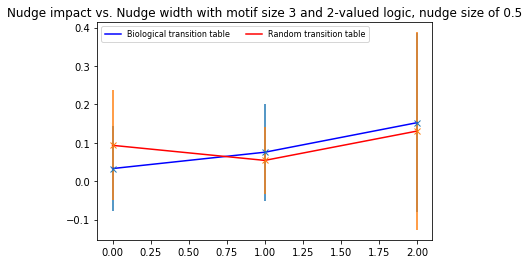

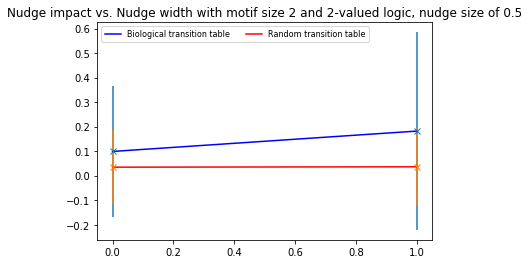

In [11]:
for i in range(0, len(samples)):
    values = []
    colors = []
    labels = []
    for j in range(0, samples[i]["network_size"]):
        x_value = j
        y_values = []
        # the random tables
        for sample in samples[i]["random_tables"]:
            if sample[2][j][1] is not None:
                y_values.append(sample[2][j][1])
        colors.append("red")
        labels.append("Random transition table")
        values.append([x_value, y_values])

        x_value = j
        y_values = []
        # the bio table
        for sample in samples[i]["bio_tables"]:
            if sample[2][j][1] is not None:
                y_values.append(sample[2][j][1])
        colors.append("blue")
        labels.append("Biological transition table")
        values.append([x_value, y_values])
        
    title = "Nudge impact vs. Nudge width with motif size %s and %s-valued logic, nudge size of %s" % (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"])
    axes_labels = ["Nudge impact","Synergy"]
        
    results_location = "../../data/n=%d_l=%d_e=%f_%s_%s_nosamples=%d" % (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], nudge_method, synergy_measure, len(samples[i]))
    filename = os.path.join(results_location, "memory.pdf")
    
    visualize.plot_line(values, colors, labels, title, filename=os.path.join(results_location, filename), axes_labels=None)